In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,peak_prominences
from opensignalsreader import OpenSignalsReader
from numpy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
import scipy.signal as sig
%matplotlib inline

Importamos los datos del .txt generado por OpenSignals y los pasamos a un formato legible para la función de scipy find_peaks,  extraemos los datos necesarios y excluímos los datos pertenecientes a otros complejos, ondas y el ruido seleccionando un rango de alturas razonable para después hacer una media del valor de los picos y llevarlos a nuestro estudio.

In [3]:
def findHeight (data,peaks):
    mins = [0]
    maxs = [0]
    rango = [0]
    for i in range(0,len(peaks)):
        rango = data[int(peaks[i])-80:int(peaks[i])+120]
        mins.append(min(rango))
        maxs.append(max(rango))
    heights = np.zeros_like(mins)
    for i in range(0,len(maxs)):
        heights[i]=maxs[i]-mins[i]
    return heights

def conversor (data):
    datos = np.zeros_like(data)
    n = 10 #channel bits
    VCC = 3.3 #operating voltage (V)
    Gecg = 1100 #ganancia del sensor
    for i in range(0,len(data)):
        datos[i] = ((((data[i]/(pow(2,n)))-(1/2))*VCC)/Gecg)*1000
    return datos

media amplitudes = 0.4646484375
tiempo transcurrido: 77.4 picos detectados: 114
frecuencia cardiaca = 88.37209302325581


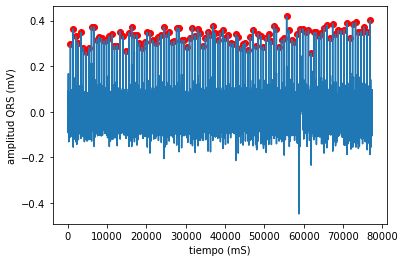

In [12]:
acq = OpenSignalsReader('paciente_60.txt')
data = acq.raw('ECG') #valores que toma el ECG

converted_data = conversor(data[:]) #datos en mV
peaks, _ = find_peaks(converted_data,height=[0.0,2.0],prominence = 0.35,distance = 300) #posición de los picos del ECG
alturas = findHeight(converted_data,peaks)
print('media amplitudes = ' + str(np.mean(alturas))) #media de las amplitudes del complejo QRS del ECG

print('tiempo transcurrido: ' + str(converted_data.size/1000) + ' picos detectados: ' + str(peaks.size)) #intervalo de tiempo (S) en el que se realizó el experimento y picos válidos para el estudio
print('frecuencia cardiaca = ' + str((peaks.size/(converted_data.size/1000))*60)) #frecuencia cardiaca
values = converted_data[peaks] #valores de los picos del ECG
plt.xlabel('tiempo (mS)')
plt.ylabel('amplitud QRS (mV)')
plt.plot(peaks,values, "or",); plt.plot(converted_data);
plt.show()

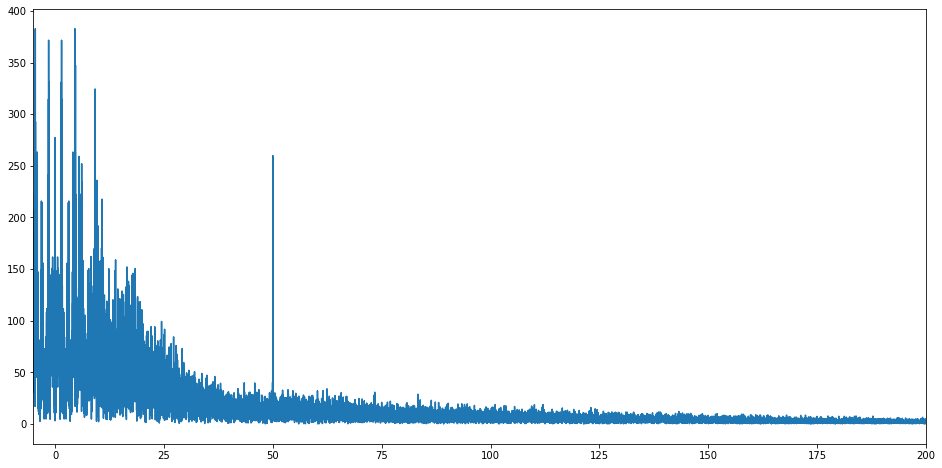

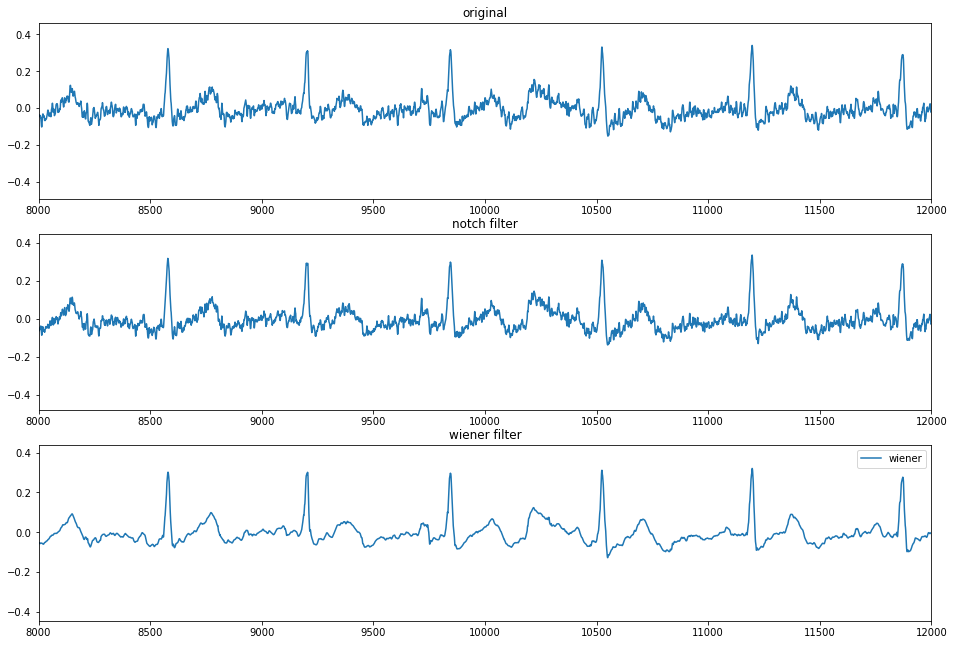

In [22]:
fs = 1000
X = fft(converted_data)
F = fftfreq(len(X))
f = F * fs

X = fftshift(X)
f =fftshift(f)

plt.figure(figsize=(16,8))
plt.plot(f,abs(X))
plt.xlim(-5,200)

Nwindow = 21
xwiener = sig.wiener(converted_data, Nwindow) #ESTE ES EL ECG CON EL MEJOR FILTRO

fnyquist = fs / 2
fnotch = 50 / fnyquist
b, a = sig.iirnotch(fnotch, 10)
x1_filtered = sig.filtfilt(b, a, converted_data)

plt.figure(figsize=(16,11))
plt.subplot(311)
plt.plot(converted_data, label = "original")
plt.title('original')
plt.xlim(8000,12000)
plt.subplot(312)
plt.plot(x1_filtered, label = "notch")
plt.title('notch filter')
plt.xlim(8000,12000)
plt.subplot(313)
plt.plot(xwiener, label = "wiener")
plt.title('wiener filter')
plt.xlim(8000,12000)
plt.legend()